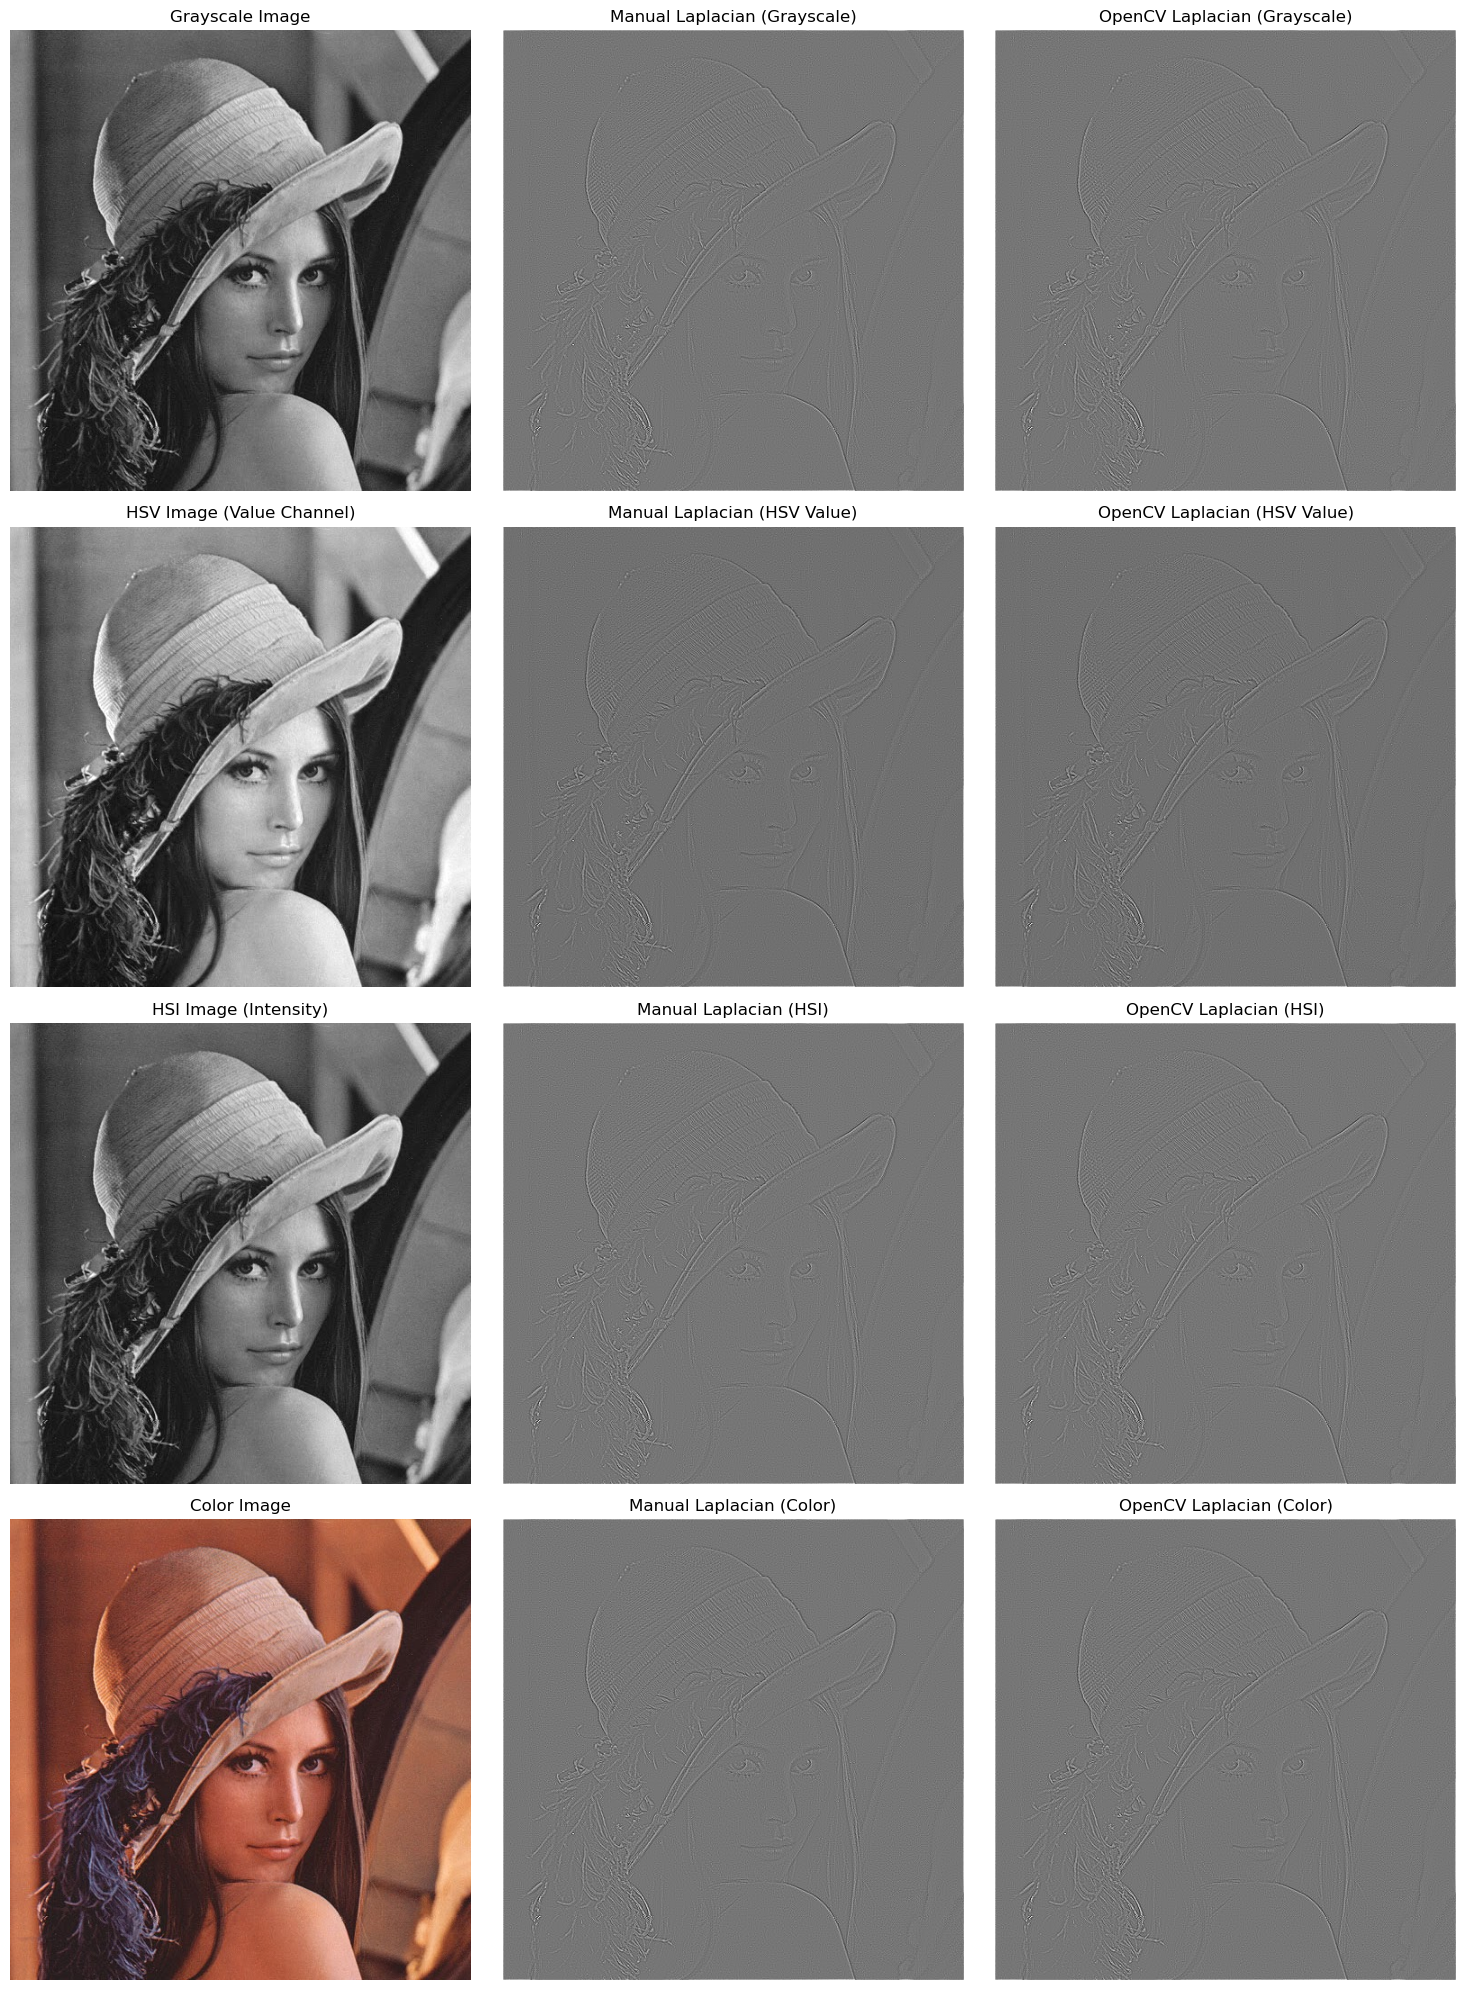

In [14]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ================================================================
# Theoretical Concepts:
# ================================================================
# 1. Grayscale Conversion:
# - Grayscale conversion is the process of converting a colored image to shades of gray.
# - Each pixel in a grayscale image has only intensity values, ranging from black (0) to white (255).
# - A common method is using the average of the RGB channels or weighted sums for more accurate results.

# Mathematically, for an image with RGB channels:
# Gray = (R + G + B) / 3    (simple average method)

# ================================================================
# 2. Laplacian Filter:
# - The Laplacian filter is used to highlight regions of rapid intensity change, detecting edges.
# - It's a second-order derivative filter, capturing changes in pixel intensity in both x and y directions.
# - The kernel used for the Laplacian filter is often a 3x3 matrix that calculates the Laplacian in the spatial domain.

# Mathematically, the discrete Laplacian operator is given by:
# Laplacian(I) = I(x+1, y) + I(x-1, y) + I(x, y+1) + I(x, y-1) - 4*I(x, y)
# where I(x, y) represents the pixel intensity at position (x, y).

# ================================================================
# 3. RGB to HSI Conversion:
# - The HSI (Hue, Saturation, Intensity) model is a color model that is often more intuitive for humans.
# - Hue represents the color itself, Saturation represents the vividness, and Intensity represents brightness.

# The conversion from RGB to HSI is as follows:
# - Hue (H): The angle in the RGB color space, calculated using the arccos function.
# - Saturation (S): The degree of color intensity.
# - Intensity (I): The average of the RGB components.

# ================================================================
# 4. RGB to HSV Conversion:
# - The HSV (Hue, Saturation, Value) color model represents colors in terms of their shade (Hue),
#   intensity of color (Saturation), and brightness (Value).
# - The Value channel is particularly useful for edge detection and other image processing tasks.

# ================================================================
# Code for image processing starts here:
# ================================================================

# =======================
# RGB to Grayscale Conversion:
# =======================
# Load the image
image_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')  # Replace with your image path
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert to Grayscale (using the simple average method)
gray_image = np.mean(image, axis=2).astype(np.float32)

# Laplacian kernel (3x3)
laplacian_kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
], dtype=np.float32)

# Apply zero padding to the grayscale image (pad with zeros)
padded_gray = np.pad(gray_image, pad_width=1, mode='constant', constant_values=0)

# Function to manually apply the Laplacian filter to the grayscale image
def apply_laplacian_gray(channel, kernel, padded_channel):
    height, width = channel.shape
    result = np.zeros_like(channel, dtype=np.float32)  # Ensure the result is of the correct type

    # Iterate over all pixels (including borders)
    for i in range(height):
        for j in range(width):
            # Apply the kernel to the 3x3 region around the pixel (considering padding)
            region = padded_channel[i:i+3, j:j+3]
            result[i, j] = np.sum(region * kernel)
    
    return result

# Apply the manual Laplacian filter to the grayscale image
manual_laplacian_gray = apply_laplacian_gray(gray_image, laplacian_kernel, padded_gray)

# OpenCV Laplacian (using filter2D)
laplacian_cv_gray = cv2.filter2D(gray_image.astype(np.float32), -1, laplacian_kernel, borderType=cv2.BORDER_CONSTANT)

# Apply Laplacian to the color image (for both manual and OpenCV)
gray_image_color = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert RGB to grayscale for color image

# Apply zero padding to the grayscale color image
padded_gray_color = np.pad(gray_image_color, pad_width=1, mode='constant', constant_values=0)

# Apply manual Laplacian on color image
manual_laplacian_color = apply_laplacian_gray(gray_image_color, laplacian_kernel, padded_gray_color)

# OpenCV Laplacian (using filter2D) on color image
laplacian_cv_color = cv2.filter2D(gray_image_color.astype(np.float32), -1, laplacian_kernel, borderType=cv2.BORDER_CONSTANT)

# =======================
# RGB to HSI Conversion:
# =======================
def rgb_to_hsi(image):
    # Normalize the RGB values
    R, G, B = image[..., 0] / 255.0, image[..., 1] / 255.0, image[..., 2] / 255.0

    # Compute Intensity
    I = (R + G + B) / 3.0

    # Compute Saturation
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1 - 3 * (min_rgb / (R + G + B + 1e-6))

    # Compute Hue
    num = 0.5 * ((R - G) + (R - B))
    denom = np.sqrt((R - G)**2 + (R - B) * (G - B))
    theta = np.arccos(np.clip(num / (denom + 1e-6), -1.0, 1.0))

    # Assign Hue
    H = np.degrees(theta)
    H[B > G] = 360 - H[B > G]

    # Stack the channels together
    HSI_image = np.stack([H, S, I], axis=-1)
    
    return HSI_image

# Convert to HSI
hsi_image = rgb_to_hsi(image)

# Apply Laplacian on HSI Image
gray_hsi_image = hsi_image[..., 2]  # Intensity channel for Laplacian
padded_gray_hsi = np.pad(gray_hsi_image, pad_width=1, mode='constant', constant_values=0)

# Apply manual Laplacian on HSI image
manual_laplacian_hsi = apply_laplacian_gray(gray_hsi_image, laplacian_kernel, padded_gray_hsi)

# Apply OpenCV Laplacian on HSI image
laplacian_cv_hsi = cv2.filter2D(gray_hsi_image.astype(np.float32), -1, laplacian_kernel, borderType=cv2.BORDER_CONSTANT)

# =======================
# RGB to HSV Conversion:
# =======================
# Convert the image to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Extract the Value channel (V) for Laplacian processing
value_channel = hsv_image[..., 2]

# Apply zero padding to the value channel
padded_value_channel = np.pad(value_channel, pad_width=1, mode='constant', constant_values=0)

# Apply manual Laplacian on HSV Value channel
manual_laplacian_hsv = apply_laplacian_gray(value_channel, laplacian_kernel, padded_value_channel)

# Apply OpenCV Laplacian on HSV Value channel
laplacian_cv_hsv = cv2.filter2D(value_channel.astype(np.float32), -1, laplacian_kernel, borderType=cv2.BORDER_CONSTANT)

# Display the results using matplotlib with four rows
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Row 1: Grayscale image, manual Laplacian on grayscale, and OpenCV Laplacian on grayscale
axes[0, 0].imshow(gray_image, cmap='gray')
axes[0, 0].set_title("Grayscale Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(manual_laplacian_gray, cmap='gray')
axes[0, 1].set_title("Manual Laplacian (Grayscale)")
axes[0, 1].axis('off')

axes[0, 2].imshow(laplacian_cv_gray, cmap='gray')
axes[0, 2].set_title("OpenCV Laplacian (Grayscale)")
axes[0, 2].axis('off')

# Row 3: HSI image, manual Laplacian on HSI, and OpenCV Laplacian on HSI
axes[2, 0].imshow(hsi_image[..., 2], cmap='gray')  # Only the Intensity channel
axes[2, 0].set_title("HSI Image (Intensity)")
axes[2, 0].axis('off')

axes[2, 1].imshow(manual_laplacian_hsi, cmap='gray')
axes[2, 1].set_title("Manual Laplacian (HSI)")
axes[2, 1].axis('off')

axes[2, 2].imshow(laplacian_cv_hsi, cmap='gray')
axes[2, 2].set_title("OpenCV Laplacian (HSI)")
axes[2, 2].axis('off')

# Row 2: HSV image, manual Laplacian on HSV Value, and OpenCV Laplacian on HSV Value
axes[1, 0].imshow(hsv_image[..., 2], cmap='gray')  # Only the Value channel
axes[1, 0].set_title("HSV Image (Value Channel)")
axes[1, 0].axis('off')

axes[1, 1].imshow(manual_laplacian_hsv, cmap='gray')
axes[1, 1].set_title("Manual Laplacian (HSV Value)")
axes[1, 1].axis('off')

axes[1, 2].imshow(laplacian_cv_hsv, cmap='gray')
axes[1, 2].set_title("OpenCV Laplacian (HSV Value)")
axes[1, 2].axis('off')

# Row 4: Color image, manual Laplacian on color, and OpenCV Laplacian on color
axes[3, 0].imshow(image)
axes[3, 0].set_title("Color Image")
axes[3, 0].axis('off')

axes[3, 1].imshow(manual_laplacian_color, cmap='gray')
axes[3, 1].set_title("Manual Laplacian (Color)")
axes[3, 1].axis('off')

axes[3, 2].imshow(laplacian_cv_color, cmap='gray')
axes[3, 2].set_title("OpenCV Laplacian (Color)")
axes[3, 2].axis('off')

plt.tight_layout()
plt.show()
